# Comparing Eulerian fields from coupled and uncoupled simulation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import os.path
from datetime import timedelta, datetime
from geopy import distance
from glob import glob

In [49]:
outpath_data = '/Users/siren/IMMERSE_waves/develop-mac/data/Eulerian/'
outpath_figs = '/Users/siren/IMMERSE_waves/develop-mac/figures/'

## Loading Eulerian data

In [5]:
datapath = '/Users/siren/Data/IMMERSE/'
datapath_nc = datapath + 'surface_TKE_v42RC/'
datapath_c = datapath + 'surface_TKE_CO_FORCE_MIX_LC015/'

uvars_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_U.nc')),
                            chunks=None, combine='by_coords')
vvars_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_V.nc')),
                            chunks=None, combine='by_coords')
uvars_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_U.nc')),
                            chunks=None, combine='by_coords')
vvars_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_V.nc')),
                            chunks=None, combine='by_coords')

 ## Calculate mean speed and direction

In [10]:
u_Enc = uvars_nc.vozocrtx
v_Enc = vvars_nc.vomecrty
speed_Enc = (u_Enc**2 + v_Enc**2)**(1/2)

In [11]:
u_Ec = uvars_c.vozocrtx
v_Ec = vvars_c.vomecrty
speed_Ec = (u_Ec**2 + v_Ec**2)**(1/2)

In [12]:
u_Sc = uvars_c.usd
v_Sc = vvars_c.vsd
speed_Ec = (u_Sc**2 + v_Sc**2)**(1/2)

In [13]:
speed_EcSc = ((u_Ec + u_Sc)**2 + (v_Ec + v_Sc)**2)**(1/2)

In [14]:
speed_EncSc = ((u_Enc + u_Sc)**2 + (v_Enc + v_Sc)**2)**(1/2)

In [21]:
speed_Enc_ave = speed_Enc.mean(dim='time_counter').compute()
speed_Ec_ave = speed_Ec.mean(dim='time_counter').compute()
speed_EcSc_ave = speed_EcSc.mean(dim='time_counter').compute()
speed_EncSc_ave = speed_EncSc.mean(dim='time_counter').compute()

In [64]:
nav_lon = u_Ec.nav_lon.values
nav_lat = u_Ec.nav_lat.values

In [70]:
speed_ds = xr.Dataset(data_vars = {'Enc': speed_Enc_ave.where(speed_Enc_ave !=0).isel(depthu=0,depthv=0),
                                   'Ec': speed_Ec_ave.where(speed_Ec_ave !=0).isel(depthu=0,depthv=0),
                                   'EcSc': speed_EcSc_ave.where(speed_EcSc_ave !=0).isel(depthu=0,depthv=0),
                                   'EncSc': speed_EncSc_ave.where(speed_EncSc_ave !=0).isel(depthu=0,depthv=0)},
                      coords = {'nav_lon': (('y','x'),nav_lon),
                                'nav_lat': (('y','x'),nav_lat)})

In [71]:
speed_ds.to_netcdf(outpath_data + 'Speed-ave.nc')

In [72]:
speed_ds

<xarray.Dataset>
Dimensions:  (y: 380, x: 1307)
Coordinates:
    depthu   float32 1.018
    depthv   float32 1.018
    nav_lon  (y, x) float32 -18.1 -18.06 -18.02 -17.98 ... -1.0 -1.0 -1.0 -1.0
    nav_lat  (y, x) float32 30.19 30.19 30.19 30.19 ... -1.0 -1.0 -1.0 -1.0
Dimensions without coordinates: y, x
Data variables:
    Enc      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Ec       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    EcSc     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    EncSc    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_18242/498445585.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(speed_ds.nav_lon, speed_ds.nav_lat,


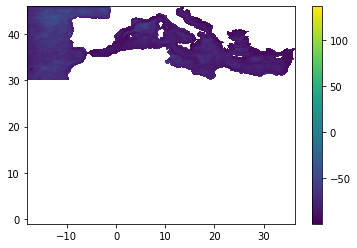

In [77]:
map = plt.pcolor(speed_ds.nav_lon, speed_ds.nav_lat,
                 (speed_ds.Ec - speed_ds.Enc)/speed_ds.Enc*100,
                shading='nearest')
plt.colorbar(map)

## Estimating impact of current-wave coupling on mean velocity

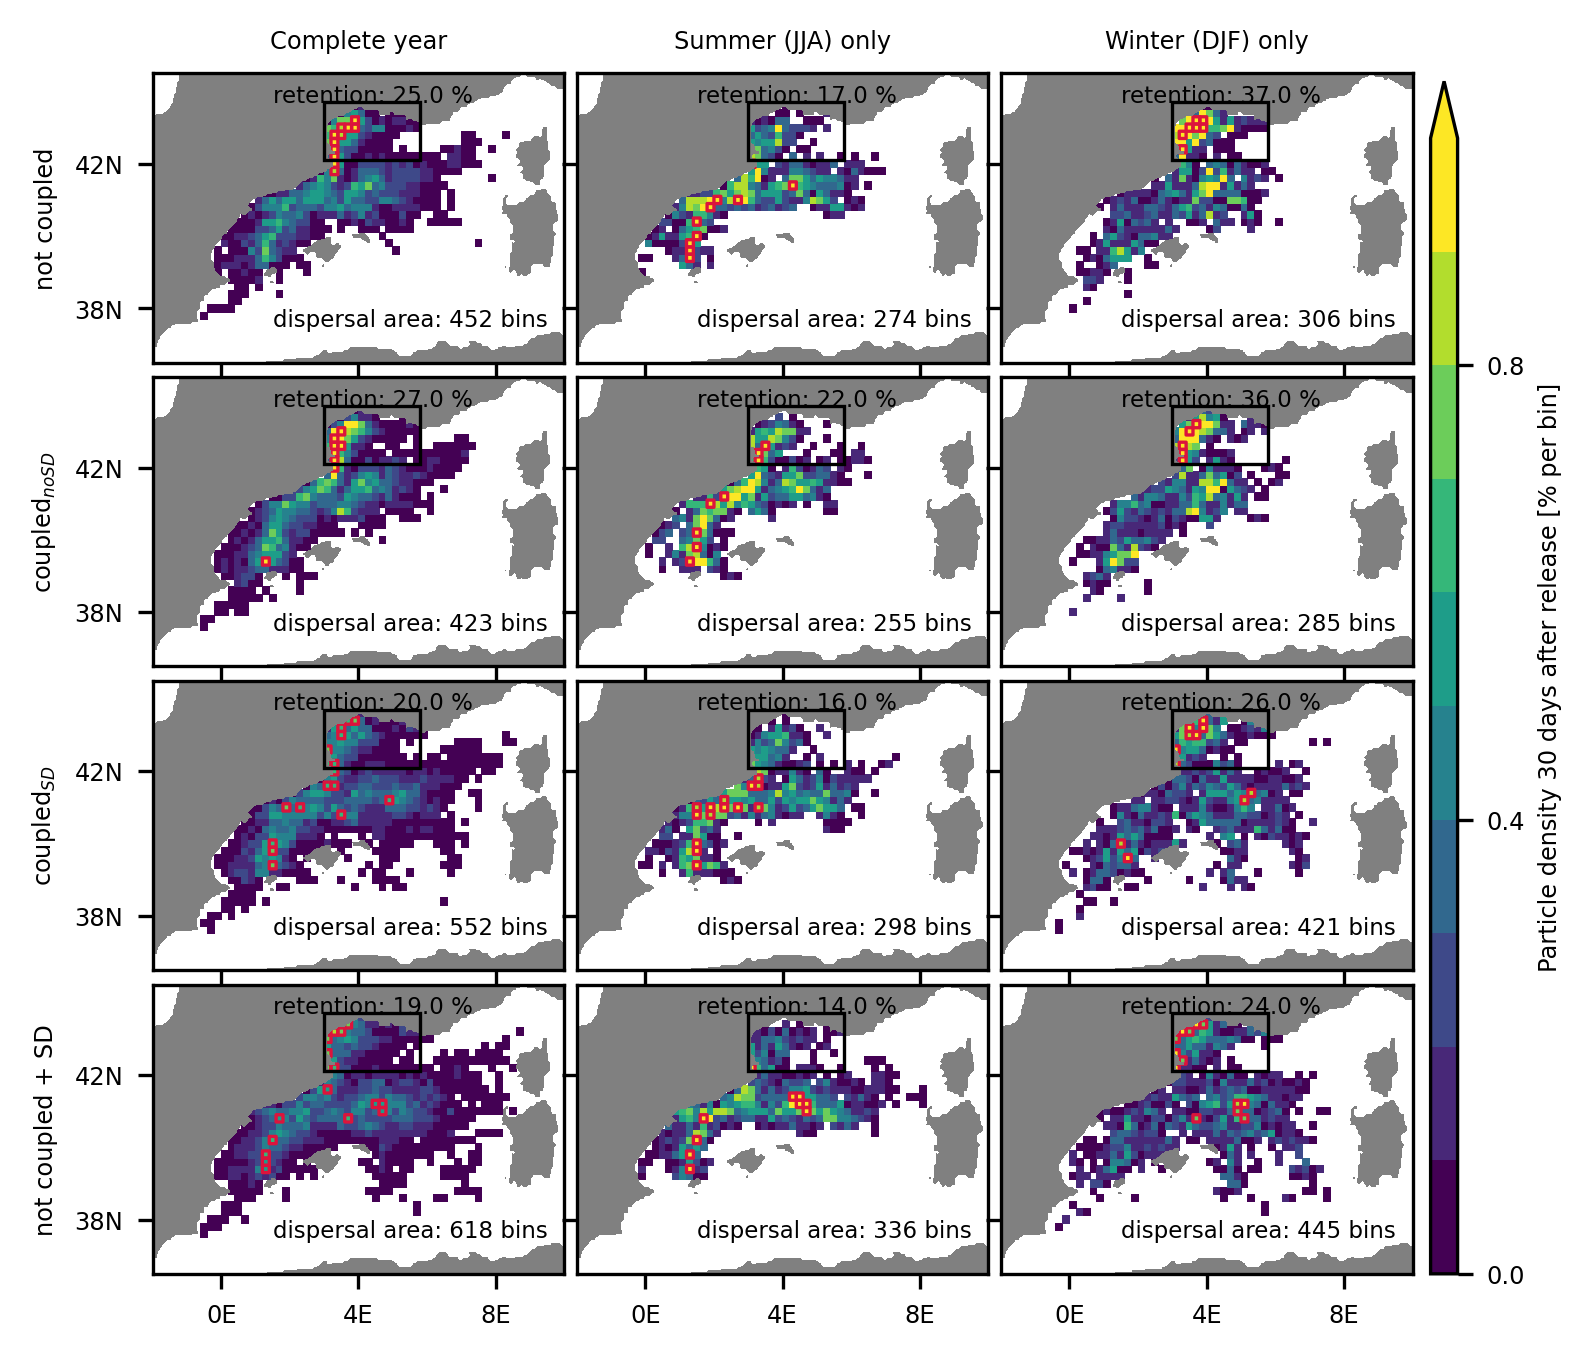

In [75]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.viridis 
levs = np.arange(0, 1.1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhist(var1):
    pos_y = var1.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_x = var1.isel(obs=30).lon.stack(trajstack=('traj','start'))
    #pos_y = var1.lat.stack(trajstack=('traj','start','obs'))
    #pos_x = var1.lon.stack(trajstack=('traj','start','obs'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm = norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.annotate('retention: ' + str(retention.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins = (hist2D_plot.where(hist2D_plot != 0)/hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(1.5, 37.5, 'dispersal area: ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5)
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin','lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def build_subplot(var1,var2,speccolor,xticklabel=True,yticklabel=True):
    map = plot_2Dhist(var1)
    plot_bathy()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0E','4E','8E'])
    ax.set_yticklabels(['38N','42N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot(var1,var2,col_nc, xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('not coupled', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_cnosd
var2 = dist_cnosd
map = build_subplot(var1,var2,col_cnosd, xticklabel=False)
ax.set_ylabel('coupled$_{noSD}$', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot(var1,var2,col_csd, xticklabel=False)
ax.set_ylabel('coupled$_{SD}$', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot(var1,var2,col_ncsd)
ax.set_ylabel('not coupled + SD', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)


# Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)
ax.text(14, 53, 'Particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


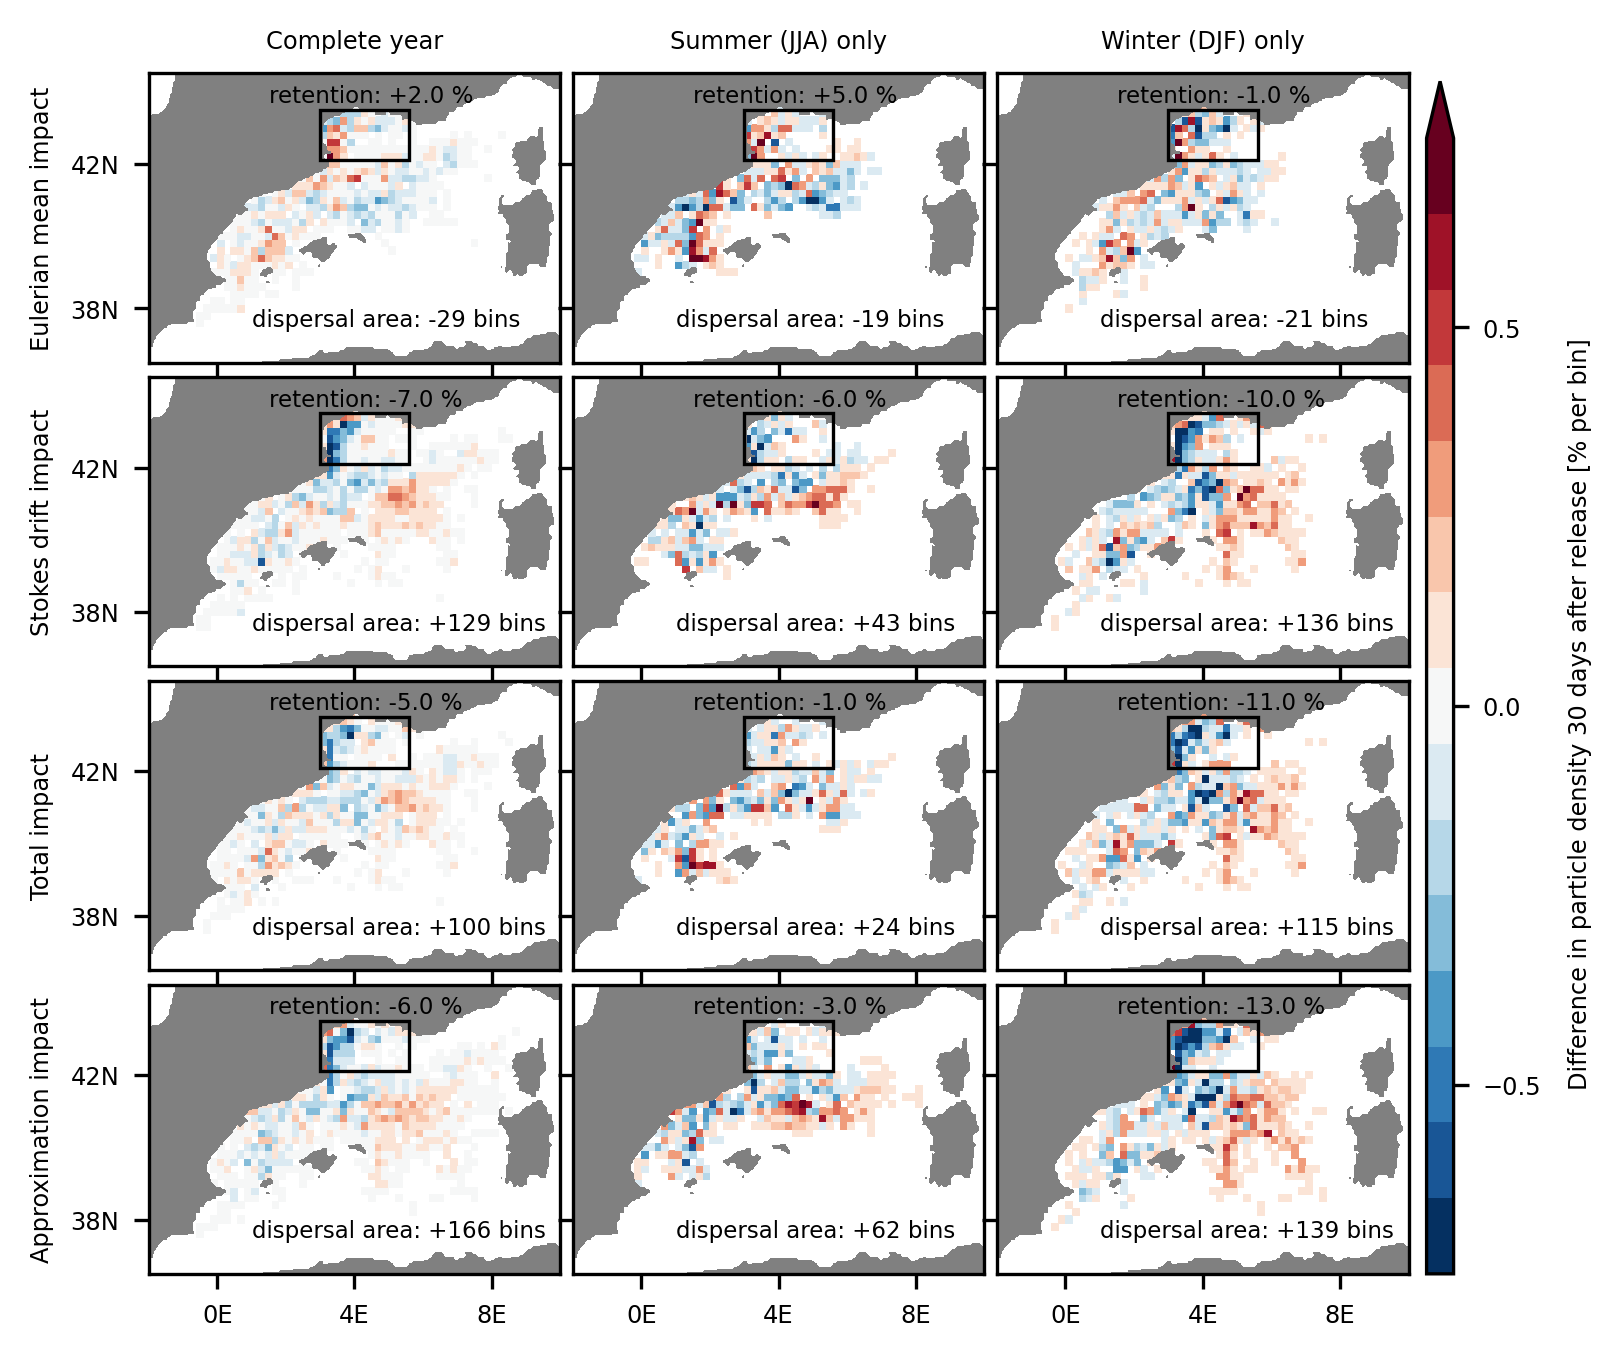

In [46]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2
lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.RdBu_r 
levs = np.arange(-0.8, 0.8, 0.1)
norm = colors.BoundaryNorm(boundaries=levs+0.05, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhistdiff(var1,var2):
    pos_1y = var1.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_1x = var1.isel(obs=30).lon.stack(trajstack=('traj','start'))
    hist2D_1 = histogram(pos_1x, pos_1y, bins=[bins_lon, bins_lat])
    hist2D_plot_1 = hist2D_1.transpose()/hist2D_1.sum().values*100
    pos_2y = var2.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_2x = var2.isel(obs=30).lon.stack(trajstack=('traj','start'))
    hist2D_2 = histogram(pos_2x, pos_2y, bins=[bins_lon, bins_lat])
    hist2D_plot_2 = hist2D_2.transpose()/hist2D_2.sum().values*100
    hist2ddiff = hist2D_plot_1 - hist2D_plot_2
    map = ax.pcolor(hist2ddiff.lon_bin, hist2ddiff.lat_bin,
                    hist2ddiff.where(hist2ddiff != 0),
                    cmap=colm, norm=norm,
                    shading='nearest')
    #plt.colorbar(map)
    release_box = (((hist2D_plot_1.lon_bin >= lonmin) & (hist2D_plot_1.lon_bin <= lonmax)) &
                   ((hist2D_plot_1.lat_bin >= latmin) & (hist2D_plot_1.lat_bin <= latmax)))
    retention1 = hist2D_plot_1.where(release_box).sum()
    retention2 = hist2D_plot_2.where(release_box).sum()
    retentiondiff = retention1 - retention2
    if retentiondiff < 0:
        ax.annotate('retention: -' + str(np.abs(retentiondiff.round().values)) + ' %', (1.5, latmax+step), fontsize=5.5)
    if retentiondiff > 0:
        ax.annotate('retention: +' + str(retentiondiff.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins_1 = (hist2D_plot_1.where(hist2D_plot_1 != 0)/hist2D_plot_1.where(hist2D_plot_1 != 0)).sum()
    area_bins_2 = (hist2D_plot_2.where(hist2D_plot_2 != 0)/hist2D_plot_2.where(hist2D_plot_2 != 0)).sum()
    area_bins_diff = area_bins_1 - area_bins_2
    if area_bins_diff < 0:
        ax.text(1, 37.5, 'dispersal area: -' + str(np.abs(int(area_bins_diff.round().values))) + ' bins', fontsize=5.5)
    if area_bins_diff > 0:
        ax.text(1, 37.5, 'dispersal area: +' + str(int(area_bins_diff.round().values)) + ' bins', fontsize=5.5)
    return map
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_2Dhistdiff(var1,var2)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0E','4E','8E'])
    ax.set_yticklabels(['38N','42N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_cnosd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('Eulerian mean impact', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_csd
var2 = traj_cnosd
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Stokes drift impact', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Total impact', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot(var1,var2)
ax.set_ylabel('Approximation impact', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)


#Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)
ax.text(15, 52, 'Difference in particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()
